In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#Imports needed
import numpy as np #For everything                              version 
import matplotlib.pyplot as plt #For visualisation              version 
import networkx as nx #For the graph                            version 
from pickle import load as pload #For loading the gpickle file  version 
from PIL import Image #For image management                     version 
from tqdm import tqdm #For nice loading bars                    version 
from declaration_tutti import load, treat_a_new_reseau, load_from_scratch
from fct_utils import prune,xy2t
from fct_analyse import arbre_genealogique_branches,color_by_time
#Our part:
from Reseau import Reseau,Brindille,Branche 
from scipy.optimize import curve_fit
from IPython.display import Image


def n2branch(node): 
    list = []
    for b in reseau.branches: 
        for i in  b.noeuds:     
            if i == node: 
                list.append(b)      
    return list 

In [6]:
def vision_des_branches(reseau, t, rayon, demi_angle, show):
    """
    Renvoie à l'instant t si le champ de vision des branches présentes est occupé ou libre
    sous la forme d'un dictionnnaire {b.index: isFree?}
    Le champ de vision est un cone d'angle 2*'demi_angle' et de rayon 'rayon'.
    """
    isFree = {}
    obstacles = {}  # Dictionary to store obstacles for each branch
    branches = [b for b in reseau.branches if b.get_tstart() < t <= b.get_tend()]
    noeuds_actifs = [n for n in reseau.g.nodes if reseau.n2t[n] <= t]
    n2index = {n: i for i, n in enumerate(noeuds_actifs)}
    index2n = {i: n for i, n in enumerate(noeuds_actifs)}
    xx = np.array([reseau.n2x[n] for n in noeuds_actifs])
    xmin, xmax = np.min(xx) - reseau.diameter, np.max(xx) + reseau.diameter
    yy = np.array([reseau.n2y[n] for n in noeuds_actifs])
    ymin, ymax = np.min(yy) - reseau.diameter, np.max(yy) + reseau.diameter
    maillages = np.zeros(shape=(int((xmax - xmin) // rayon) + 1,
                                int((ymax - ymin) // rayon) + 1,
                                len(noeuds_actifs)),
                         dtype=bool)
    imax, jmax, kmax = maillages.shape
    
    def xy2ij(x, y):
        """
        given x,y coordinates of a node, find the i,j coordinates in the matrix 'maillages'
        """
        i = int((x - xmin) // rayon)
        j = int((y - ymin) // rayon)
        return i, j
    
    # Initialistation du maillage
    pos = {n: (reseau.n2x[n], reseau.n2y[n]) for n in noeuds_actifs}
    for k, n in enumerate(noeuds_actifs):
        i, j = xy2ij(*pos[n])
        maillages[i, j, k] = True
    
    g = nx.subgraph(reseau.g, noeuds_actifs).copy()
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        nx.draw(g, pos=pos, ax=ax, node_size=2)
        ax.imshow(reseau.image_at(t), cmap="Greys")
    
    for b in branches:
        color = "black"
        apex = b.get_apex_at(t)
        i, j = xy2ij(*pos[apex])
        
        # Find neighbors
        noeuds_potentiels = np.zeros_like(noeuds_actifs, dtype=bool)
        for im in range(max(i - 1, 0), min(i + 2, imax)):
            for jm in range(max(j - 1, 0), min(j + 2, jmax)):
                noeuds_potentiels = np.where(maillages[im, jm, :], True, noeuds_potentiels)
        
        noeuds_potentiels[n2index[apex]] = False
        filtre = np.where(noeuds_potentiels)
        
        distance = np.sqrt((xx[filtre] - reseau.n2x[apex]) ** 2 +
                           (yy[filtre] - reseau.n2y[apex]) ** 2)
        
        try:
            pre_apex = b.get_apex_at(t - 1)
        except ValueError:
            pre_apex = b.noeuds[0]
        
        direction = np.array([reseau.n2x[apex] - reseau.n2x[pre_apex],
                              reseau.n2y[apex] - reseau.n2y[pre_apex]])
        direction = direction / np.linalg.norm(direction)
        theta = np.arctan2(direction[1], direction[0])
        direction_ort = np.array([direction[1], -direction[0]])
        
        if np.any(distance < rayon):
            # We check for angle
            axes = np.array([xx[filtre] - reseau.n2x[apex],
                             yy[filtre] - reseau.n2y[apex]]).T

            angle = np.arctan2(np.dot(axes, direction_ort),
                               np.dot(axes, direction))

            test = np.logical_and(distance <= rayon,
                                  np.logical_and(angle <= demi_angle,
                                                 angle >= -demi_angle))

            isFree[b.index] = not np.any(test)

            if not isFree[b.index]:
                obstacle_indices = np.where(test)[0]

                if len(obstacle_indices) > 0:
                    temp =  [index2n[filtre[0][i]] for i in obstacle_indices]
                    obstacles[b.index] = {
                        'obstacles': temp ,
                        'distances': distance[test].tolist()
                    }
                    
                    
        obstacles_branches= {}
        for index, value in obstacles.items(): 
            obstacles_branches[index] = []
            gay = value['obstacles']
            if gay != None:
                for j in gay: 
                    f = n2branch(j)
                    obstacles_branches[index].append(f)
                    
                    
        if show:
            color = "green" if isFree[b.index] else "red"
            ax.plot([reseau.n2x[apex] + t * rayon * direction[0] for t in (0, 1)],
                    [reseau.n2y[apex] + t * rayon * direction[1] for t in (0, 1)],
                    color=color, ls='--')
            ax.plot([reseau.n2x[apex] + t * rayon * np.cos(theta + demi_angle) for t in (0, 1)],
                    [reseau.n2y[apex] + t * rayon * np.sin(theta + demi_angle) for t in (0, 1)],
                    color=color, ls='--')
            ax.plot([reseau.n2x[apex] + t * rayon * np.cos(theta - demi_angle) for t in (0, 1)],
                    [reseau.n2y[apex] + t * rayon * np.sin(theta - demi_angle) for t in (0, 1)],
                    color=color, ls='--')
            ax.plot([reseau.n2x[apex] + rayon * np.cos(theta + alpha) for alpha in np.linspace(-demi_angle, +demi_angle, 10)],
                    [reseau.n2y[apex] + rayon * np.sin(theta + alpha) for alpha in np.linspace(-demi_angle, +demi_angle, 10)],
                    color=color, ls='--')
    
    if show:
        ax.set_xlim([xmin - rayon, xmax + rayon])
        ax.set_ylim([ymin - rayon, ymax + rayon])
        fig.savefig(reseau.output_dir + f"Branches/collision_{t:02d}.jpg")
        plt.show()
    
    return isFree, obstacles , obstacles_branches 

In [7]:
reseau= load('M2WT_200616',"branched")
for b in reseau.branches:
        b.n2x = reseau.n2x
        b.n2y = reseau.n2y
        b.n2t = reseau.n2t

C:\Users\alice\AppData\Local\Temp\ipykernel_10940\662147992.py:68: RuntimeWarning: invalid value encountered in divide
  direction = direction / np.linalg.norm(direction)


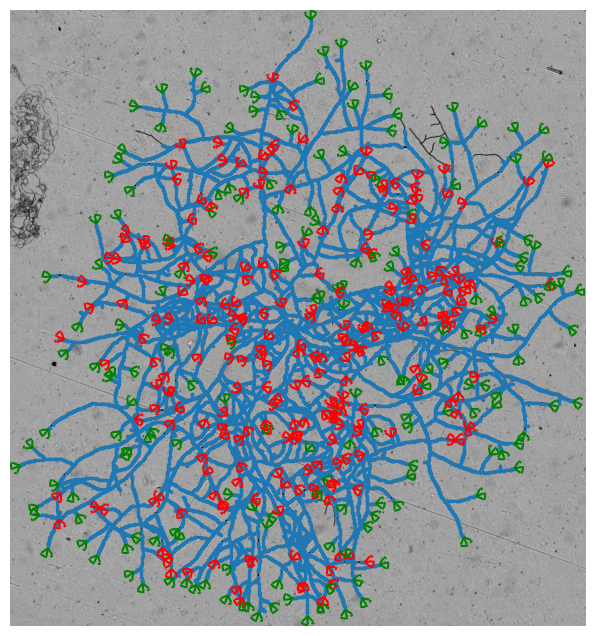

In [8]:
isFree, obstacles ,obstacles_branches = vision_des_branches(reseau, t = 50, rayon = 62.5, demi_angle = 0.8 , show = True)

In [9]:
def extract_obstacles_branches(obstacles):
    obstacles_branches = {}
    
    for index, data in obstacles.items():
        nodes = data['obstacles']
        distances = data['distances']
        
        branches = []
        for node in nodes:
            branches.extend(n2branch(node))
        
        obstacles_branches[index] = {
            'branches': branches,
            'distances': distances
        }
    
    return obstacles_branches


def find_closest_obstacle():
    closest_obstacles = {}
    obstacle_branches = extract_obstacles_branches(obstacles)

    for index in obstacle_branches.keys():  # Corrected variable name here
        branches = obstacle_branches[index]['branches']  # Corrected variable name here
        distances = obstacle_branches[index]['distances']  # Corrected variable name here
        
        if branches and distances:
            min_distance_index = distances.index(min(distances))
            closest_branch = branches[min_distance_index]
            closest_distance = distances[min_distance_index]
            
            closest_obstacles[index] = {
                'branch': closest_branch,
                'distance': closest_distance
            }
    
    return closest_obstacles


In [10]:
obstacle_branches = extract_obstacles_branches(obstacles)
print(obstacle_branches)

{38: {'branches': [Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds, Branche 45 - 61 noeuds, Branche 42 - 15 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 42 - 15 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 45 - 61 noeuds, Branche 42 - 15 noeuds, Branche 42 - 15 noeuds], 'distances': [26.853770684952234, 41.72079817069659, 39.81362831996099, 42.86752850351884, 37.270967253346136, 45.311422400979644, 46.14244250145413, 42.943276540105785, 37.01519958071279, 46.396389945770565, 30.

In [ ]:
find_closest_obstacle()

In [ ]:
start_time = 16
end_time = 17
step = 1
num_columns = 2
num_rows = 1

# Select branches
branches = reseau.branches[1],reseau.branches[839]

# Calculate total number of subplots needed
total_plots = len(range(start_time, end_time + 1, step))
num_rows_needed = total_plots // num_columns + (1 if total_plots % num_columns != 0 else 0)

# Create a figure and axis
fig, axs = plt.subplots(num_rows_needed, num_columns, figsize=(16, 16))

# Loop over time values
for idx, t in enumerate(range(start_time, end_time + 1, step)):
    # Calculate subplot index
    row = idx // num_columns
    col = idx % num_columns

    # Display the image for the current time
    if num_rows_needed == 1:
        ax = axs[col]
    else:
        ax = axs[row, col]
    ax.imshow(reseau.image_at(t), cmap="Greys")
    ax.axis("off")

    # Plot selected branches
    for b in branches:
        ax.plot([b.n2x[n] for n in b.noeuds],
                [b.n2y[n] for n in b.noeuds],alpha=0.5)

    # Get the minimum and maximum coordinates of the selected branches
    x_values = [b.n2x[n] for b in branches for n in b.noeuds]
    y_values = [b.n2y[n] for b in branches for n in b.noeuds]

    min_x, max_x = min(x_values)-10 , max(x_values)+10
    min_y, max_y = min(y_values)-10, max(y_values)+10
    # Set limits to zoom in on the selected branches
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    ax.set_title(f"Time: {t}")

#plt.tight_layout()
plt.show()
plt.close()

In [ ]:
reseau.branches[839].get_tend()